In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/converted.zip" "converted.zip"

In [ ]:
!unzip -q converted.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 5 # We use a small batch size here for training
batch_size_test = 10 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('converted/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: LYM


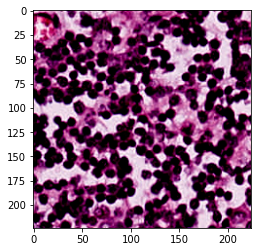

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # down sampling done by batch norm-> conv1x1-> avg pool
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)


class Bottlenecklayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        
        inner_channel = 4 * growth_rate

        # For bottleneck layer batch norm->relu->1x1 conv->batch norm->relu->1x1 conv
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)



class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=9):
        super().__init__()
        self.growth_rate = growth_rate

        
        inner_channels = 2 * growth_rate

        
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False) 

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            out_channels = int(reduction * inner_channels)
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121():
    return DenseNet(Bottlenecklayer, [6,12,24,16], growth_rate=32)

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = densenet121().to(device)
learning_rate = 0.0005
weight_decay = 0.001
for param in model.parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        
        with torch.no_grad():
            
            output = model(data)
        # compute the loss function 
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import os.path
from os import path

num_epoch = 30
train_loss=[]
test_loss=[]
accuracy_test=[]
acc=0
for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("DenseNet9SGD.pth"):
        os.remove("DenseNet9SGD.pth")

      torch.save(model.state_dict(), 'DenseNet9SGD.pth')
      acc=acct
    train_loss.append(tl)
    test_loss.append(stl)
    accuracy_test.append(acct)
!cp DenseNet9SGD.pth '/content/drive/My Drive/SGD/'

print(acc)

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.9242

Test: Average loss: 0.9945, Accuracy: 4013/5400 (74.31%)

2


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.5495

Test: Average loss: 1.3574, Accuracy: 4463/5400 (82.65%)

3


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.4245

Test: Average loss: 1.4450, Accuracy: 4168/5400 (77.19%)

4


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3432

Test: Average loss: 0.6432, Accuracy: 4820/5400 (89.26%)

5


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3007

Test: Average loss: 1.1157, Accuracy: 4660/5400 (86.30%)

6


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2492

Test: Average loss: 0.5922, Accuracy: 4848/5400 (89.78%)

7


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2428

Test: Average loss: 0.4850, Accuracy: 4938/5400 (91.44%)

8


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2149

Test: Average loss: 0.3484, Accuracy: 4979/5400 (92.20%)

9


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1925

Test: Average loss: 1.1054, Accuracy: 4955/5400 (91.76%)

10


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1810

Test: Average loss: 1.1963, Accuracy: 4907/5400 (90.87%)

11


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1671

Test: Average loss: 0.9744, Accuracy: 4714/5400 (87.30%)

12


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1589

Test: Average loss: 1.1481, Accuracy: 4894/5400 (90.63%)

13


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1422

Test: Average loss: 0.5932, Accuracy: 5144/5400 (95.26%)

14


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1388

Test: Average loss: 0.5498, Accuracy: 5007/5400 (92.72%)

15


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1322

Test: Average loss: 0.8308, Accuracy: 4984/5400 (92.30%)

16


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1177

Test: Average loss: 1.2864, Accuracy: 4987/5400 (92.35%)

17


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1161

Test: Average loss: 1.5878, Accuracy: 4677/5400 (86.61%)

18


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1124

Test: Average loss: 0.7589, Accuracy: 5081/5400 (94.09%)

19


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1098

Test: Average loss: 1.7358, Accuracy: 5147/5400 (95.31%)

20


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1127

Test: Average loss: 0.6193, Accuracy: 5056/5400 (93.63%)

21


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0936

Test: Average loss: 1.3991, Accuracy: 5109/5400 (94.61%)

22


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0983

Test: Average loss: 1.0285, Accuracy: 5191/5400 (96.13%)

23


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0889

Test: Average loss: 0.7772, Accuracy: 5140/5400 (95.19%)

24


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0899

Test: Average loss: 0.5137, Accuracy: 5166/5400 (95.67%)

25


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0872

Test: Average loss: 0.4893, Accuracy: 5182/5400 (95.96%)

26


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0784

Test: Average loss: 0.3999, Accuracy: 5152/5400 (95.41%)

27


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0750

Test: Average loss: 1.3213, Accuracy: 4997/5400 (92.54%)

28


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0764

Test: Average loss: 0.5603, Accuracy: 5162/5400 (95.59%)

29


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0687

Test: Average loss: 1.2368, Accuracy: 5176/5400 (95.85%)

30


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0691

Test: Average loss: 0.5213, Accuracy: 5148/5400 (95.33%)

96.12962962962963


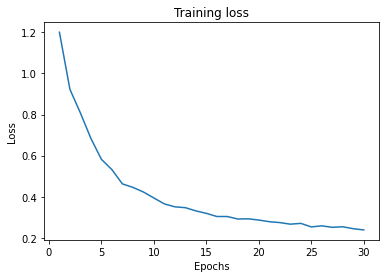

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,train_loss)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

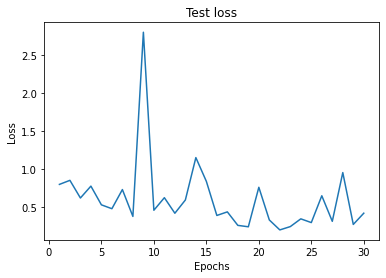

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,test_loss)
plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

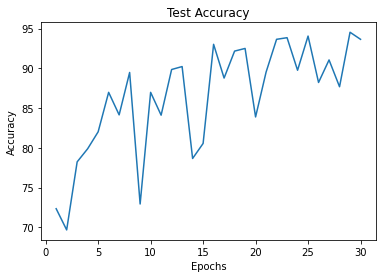

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,accuracy_test)
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()